# 10. RNN-Regression
本节主要给出RNN系列方法在回归任务中的示范代码，有关RNN等方法的介绍在这里忽略。

这里以工业软测量场景为例，给出RNN系列方法在 脱丁烷塔过程（Debutanizer Column） 中的软测量应用实现。

## 10.1 脱丁烷塔过程与软测量场景构建
脱丁烷塔是石油生产过程中脱硫和石脑油分离装置的一个重要组成部分，它将丙烷和丁烷作为石脑油流的开销而去除。由于要求尽量减少丁烷在脱丙烷器底部的含量，而直接测量该丁烷含量是很困难的，所以准确的丁烷浓度软测量模型对提高控制性能有很大的价值。

下图描述了脱丁烷塔的详细框图，其中在工厂中安装了多个硬件传感器[1]

<p align=center>
<img src="./fig/10-1.png" width=600>
</p>

收集七个典型变量（U1-U7）作为过程变量，收集丁烷浓度(butane concentration, C4)作为软测量模型的质量变量y。图中的灰色圆圈中显示了被测量的变量以及相应的名称。
<p align=center>
<img src="./fig/10-2.png" width=400>
</p>

共收集到2394个样本数据，每个样本的采样间隔为10mins[2]。**拟采用80%的数据作为训练样本集，20%的数据作为测试样本集，暂时不加入质量变量的自回归，而是考虑最朴素的过程变量回归质量变量的任务Single-shot，在多对多RNN架构下**，以构建软测量场景。

In [35]:
## Read .csv file
import pandas as pd
import numpy as np
data = pd.read_csv('./data/Debutanizer/debutanizer.csv')
data = np.array(data) # PV-data[:,:7] Qaulity-data[:,7, None]
train_ratio = 0.8
train_data = data[0:round(train_ratio*data.shape[0]),:]
test_data = data[round(train_ratio*data.shape[0]):,:]

这里首先构建[Dataset](https://www.codenong.com/cs106265477/)和[DataLoader](https://zhuanlan.zhihu.com/p/475494586)实现序列数据层面的预处理，参考序列的[随机采样和顺序分区](https://blog.csdn.net/scar2016/article/details/122513977)（跟邦邦院士讨论过）。

关于输入RNN训练的数据集划分，有很多种划分方式：

1. 随机遍历采样结合BPTT算法使用（序列的BP算法Through Time），每个batch训练的初始时刻hidden_state为0。

2. 随机采样（Aston Zhang）结合BPTT算法使用（序列的BP算法Through Time），每个batch训练的初始时刻hidden_state为0。

3. 顺序分区结合[TBPTT算法](https://www.zhihu.com/question/266402101/answer/891552204?utm_source=wechat_session&utm_medium=social&utm_oi=1298358509331902464&utm_content=group1_Answer&utm_campaign=shareopn)使用（Truncated BPTT），即batch之间的hidden_state是可传递的，训练后一个batch时会固定前一个batch最后时刻的hidden_state脱离计算图。

整体代码参考了[知乎-RNN多维输入多步非滚动时间序列预测](https://zhuanlan.zhihu.com/p/475494586)

In [36]:
## Dataset/Dataloader Definition
import torch
from torch.utils.data import Dataset, DataLoader
import random
#---------------------------------------------------------
### 1. Totally Coveraged (Dataset的item直接返回length的序列，然后搞到dataloader里面shuffle一下，1个epoch就是纯纯的遍历所有的length子序列)
## Dataset definition
class Debu_Dataset_coverage(Dataset):
    ''' Coveraged Dataset for the Debutanizer Column
    Returns:
        seq_data[length, D], seq_label[length, D_label]
    '''
    def __init__(self, data, label, length):
        # data: The imported dataset (N, D)
        # label: The imported labels (N, D_label)
        N = data.shape[0]
        self.num_seqs = N -length +1 # the num of all the seqs
        D, D_label = data.shape[1], label.shape[1]
        # Separate the whole sequence into mini_seqs
        self.seq_data = torch.zeros([self.num_seqs, length, D])
        self.seq_label = torch.zeros([self.num_seqs, length, D_label])
        for i in range(self.num_seqs):
            self.seq_data[i, :, :] = torch.from_numpy(data[i: i+length, :])
            self.seq_label[i, :, :] = torch.from_numpy(label[i: i+length, :])

    def __getitem__(self, index):
        return self.seq_data[index, :, :], self.seq_label[index, :, :]

    def __len__(self):
        return self.num_seqs

## Dataset/Dataloader Initialization
# debu_dataset_converged = Debu_Dataset_coverage(data=data[:,:7], label=data[:,7, None], length=10) # use 'None' to maintain the dim of np.array
# debu_loader_converged = DataLoader(debu_dataset_converged, batch_size=5, shuffle=True) # (batch_size, length, D)
# seq_data, seq_label = debu_dataset_converged[0]
# seq_data_batch, seq_label_batch = next(iter(debu_loader_converged))

In [37]:
#---------------------------------------------------------
### 2. Random Sampling/Sequential Partitioning（Aston Zhang里的两种方法，即包含随机性，又包含覆盖性）
def seq_data_iter(data, label, batch_size, length, is_random_iter=True):
    '''Random Sampling/Sequential Partitioning mini_seqs from the sequential data
    Returns:
        mini_seqs_data[batch_size, length, D], mini_seqs_label[batch_size, length, D_label]
    '''
    offset = random.randint(0, length-1) # offset from begining
    data_treated, label_treated = data[offset:, :], label[offset:, :]
    num_seqs = len(data_treated) // length # calculate the num of mini_seqs
    num_batches = num_seqs // batch_size # calculate the num of batches
    init_idx = list(range(0, num_seqs * length, length)) # All the possible intial indices of mini_seqs

    # Default: Sequential Partitioning, Else: Random Sampling
    if is_random_iter:
        # Random Sampling
        random.shuffle(init_idx)
    
    def mini_seq(data, position):
        '''Returns mini_seqs begining at 'position' in data
        Returns:
            mini_seq[length, D]
        '''
        return data[position:position+length, :]
    
    for i in range(0, batch_size * num_batches, batch_size):
        # Separate the mini_seqs into batches
        init_idx_per_batch = init_idx[i: i+batch_size] # the initial indices of mini_seqs in a batch
        mini_seqs_data = np.array([mini_seq(data_treated, j) for j in init_idx_per_batch])
        mini_seqs_label = np.array([mini_seq(label_treated, j) for j in init_idx_per_batch])
        yield torch.from_numpy(mini_seqs_data).to(torch.float32), torch.from_numpy(mini_seqs_label).to(torch.float32)

## DataLoader for Random Sampling/Sequential Partitioning
class SeqDataLoader:
    '''Create a iterator to load mini_seqs from sequencial data 
       Shape:[batch_size, length, D]
    '''
    def __init__(self, data, label, batch_size, length, is_random_iter=True):
        # data : Numpy array [N,D]
        # label: Numpy array [N,D_label]
        self.data, self.label = data, label
        self.batch_size, self.length = batch_size, length
        self.is_random_iter = is_random_iter
        
    def __iter__(self):
        return seq_data_iter(self.data, self.label, self.batch_size, self.length, self.is_random_iter)

    def __len__(self):
        num_seqs = len(self.data) // self.length
        num_batchs = num_seqs // self.batch_size
        return num_batchs

## Dataloader Initialization
# debu_loader_sequential = SeqDataLoader(data=data[:,:7], label=data[:,7,None], batch_size=5, length=10)
# seq_data, seq_label = next(iter(debu_loader_sequential))

而后将RNN-based方法的训练函数与验证函数给出
1. BPTT (is_random_iter = True)：随机遍历采样与随机采样，使用BPTT，每个batch训练时初始hidden_state=0
2. TBPTT (is_random_iter = False)：顺序采样，batch间hidden_state传递，但梯度截断不再往回传播。

对于随机遍历采样，其num_batchs远大于随机采样和顺序采样，随机采样的num_batches=顺序采样的num_batches。这导致随机遍历采样1个epoch的训练loss会更大。

In [38]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, device, is_random_iter):
    '''Training the RNN-based Model on the sequential data
    Remark: is_random_iter corresponds to the training scheme
    '''
    model.train()  # Open {BN, drop out} if the model has these layers
    train_loss = 0 # total loss in an epoch
    state = None   # Initial state for an epoch
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for idx, (seq_data, seq_label) in loop:
        # seq_data/seq_label [batch_size, length, D]
        # 1. Deal with the states for input
        if state is None or is_random_iter:
            # Random, which means the input states should be initialized to 0 for each batch (Or the first time in this epoch)
            state = model.begin_state(batch_size=seq_data.shape[0], device=device)
        else:
            # Sequential Partitioning, which means we should keep the states from the previous batch
            # Detachment calculation chart
            if isinstance(state, tuple): # LSTM
                for s in state:
                    s.detach_()
            else: # RNN/GRU
                state.detach_()

        # 2. Forward-Backward 
        seq_data, seq_label = seq_data.to(device), seq_label.to(device) # Initialization
        optimizer.zero_grad()
        seq_label_hat, state = model(seq_data, state) # Forward
        loss = loss_fn(seq_label_hat, seq_label) # loss
        loss.backward() # Backward

        # 3. Loss, Optimize
        train_loss += loss.item()
        optimizer.step()

        # 4. Print Results
        loop.set_postfix(loss = train_loss)
    return train_loss

def evaluate(model, eval_loader, loss_fn, device, is_random_iter):
    '''The Loss on the evaluation dataset (Assist in adjusting the hyper-parameters)
    Returns:
        eval_loss (scalar): loss on the evaluation dataset
    '''
    model.eval()
    eval_loss = 0
    state = None # Initial state
    with torch.no_grad():
        for idx, (seq_data, seq_label) in enumerate(eval_loader):
            # 1. Deal with the states for input
            if state is None or is_random_iter:
                state = model.begin_state(batch_size=seq_data.shape[0], device=device)
            else:
                if isinstance(state, tuple): # LSTM
                    for s in state:
                        s.detach_()
                else: # RNN/GRU
                    state.detach_()
            # 2. Forward, Loss
            seq_data, seq_label = seq_data.to(device), seq_label.to(device)
            seq_label_hat, state = model(seq_data, state) # Forward
            loss = loss_fn(seq_label_hat, seq_label)
            eval_loss += loss
        return eval_loss

# 可以把这两种方式都实现一下看看效果（我个人感觉两种方法都很合理，截取片段使得测试集与训练集的protocol一致，滚动使得hidden能很好地保留）
# 1.1.Random截取片段:把待预测的跟前面的组成length（相当于用前面length-1的样本warm-up），输入0状态来预测，就是知乎上的pre_seq_data_iter和predict；
# 2.1.顺序滚动：拿训练集输出的最后1个hidden_state，与待预测样本共同输入，一直保留hidden_state，设置length=1来做预测。
def predict_rand(model, pred_dataset, pre_data, length, device):
    ''' Predict with Random Scheme (use pre_data to construct the first few seqs)
    Returns:
        Y_hat[N, D_label]
    '''
    if pre_data.shape[0] < length:
        raise Exception("The number of pre_data is less than length")
    # Batch data
    num_seqs, D = pred_dataset.shape # pred_dataset[N, D]
    tmp_dataset = np.r_[pre_data[-length:, :], pred_dataset] # r_: Merge the arrays by row
    seq_data = torch.zeros([num_seqs, length, D])
    for i in range(num_seqs):
        seq_data[i, :, :] = torch.from_numpy(tmp_dataset[i:i+length, :]).to(torch.float32)

    with torch.no_grad():
        # Predict
        state = model.begin_state(batch_size=seq_data.shape[0], device=device)
        y_hat, _ = model(seq_data, state) # y_hat[batch_size, length, hidden_size]
        
        # Predict Results
        Y_hat = y_hat[:, -1, :]
    return np.squeeze(Y_hat).numpy()

def predict_roll(model, pred_dataset, warm_up_data, device):
    ''' Predict with Roll Scheme (use warm_up_data to provide the initial hidden state)
    Returns:
        Y_hat[N, D_label]
    '''
    pred_dataset = pred_dataset[None, :, :] # [batch_size=1, N, D]
    warm_up_data = warm_up_data[None, :, :] # [batch_size=1, n, D]

    with torch.no_grad():
        # Warm-up the hidden state
        state = model.begin_state(batch_size=1, device=device)
        _, state = model(torch.from_numpy(warm_up_data).to(torch.float32), state) # [num_layers, batch_size=1, hidden_size]

        # Obtain the prediction via rolling
        Y_hat, _ = model(torch.from_numpy(pred_dataset).to(torch.float32), state)
    return np.squeeze(Y_hat).numpy()

## 10.2 RNN软测量

In [39]:
## Configuration
import argparse
parser = argparse.ArgumentParser(description = "Configuration of Debu_RNN")
parser.add_argument('-l', '--length', type=int, default=20, help='Length of a seq')
parser.add_argument('-b', '--batch-size', type=int, default=8, help='Batch size')
parser.add_argument('-hs', '--hidden-size', type=int, default=16, help='Hidden size')
parser.add_argument('-n', '--num-layers', type=int, default=1, help='Number of hidden layers')
parser.add_argument('-nw', '--num-workers', type=int, default=0, help='Number of workers')
parser.add_argument('-d', '--device', type=str, default="cpu", help='Device to train model (DEFAULT: CPU)')
parser.add_argument('-e', '--epoch', type=int, default=20, help='Number of epochs')
parser.add_argument('-lr', '--learning-rate', type=float, default=1e-4, help='learning rate (DEFAULT: 1e-4)')
args = parser.parse_args(args=[]) # args=[] to make .ipynb run correctly

In [40]:
from torch import nn

class RNN(nn.Module):
    def __init__(self, args, input_size):
        super(RNN, self).__init__()
        # Define the structure of RNN
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = args.hidden_size,
            num_layers = args.num_layers,
            batch_first = True # Input X(batch, length, D)
        )
        self.out = nn.Linear(args.hidden_size, 1) # Output Y
    
    def forward(self, x, h_state):
        # Input: x(batch, length, D)
        # Hidden State: h_state(num_layers, batch, hidden_size)
        # Output of RNN: rnn_out(batch, length, hidden_size)
        rnn_out, h_state = self.rnn(x, h_state)
        outs = []
        for time_step in range(rnn_out.size(1)):
            outs.append(self.out(rnn_out[:, time_step, :])) # outs[(batch, 1, 1), (batch, 1, 1), ...]
        outs = torch.stack(outs, dim=1) # outs(batch, length, 1)
        return outs, h_state

    def begin_state(self, batch_size, device):
        h_0 = torch.zeros([self.rnn.num_layers, batch_size, self.rnn.hidden_size], device=device)
        return h_0

In [41]:
Y = test_data[:,7]
## 1. Totally Coveraged Training & Testing
print("RNN - Totally Coveraged\n")
debu_train_coverged = Debu_Dataset_coverage(data=train_data[:, :7], label=train_data[:, 7, None], length=20)
debu_trainLoader_coverged = DataLoader(debu_train_coverged, batch_size=5, shuffle=True)
RNN_coverged = RNN(args=args, input_size=7)
loss_fn_coverged = nn.MSELoss(reduction='mean')
optimizer_coverged = torch.optim.Adam(RNN_coverged.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch+1):
    train_loss = train(model=RNN_coverged, train_loader=debu_trainLoader_coverged,
        loss_fn=loss_fn_coverged, optimizer=optimizer_coverged, device=args.device, is_random_iter=True)
# Predicting
Y_hat_RNN_coverged = predict_rand(model=RNN_coverged, pred_dataset=test_data[:,:7],
    pre_data=train_data[:,:7], length=args.length, device=args.device)
pred_mse_RNN_coverged = loss_fn_coverged(torch.from_numpy(Y_hat_RNN_coverged), torch.from_numpy(Y))
print(f"Totally Coveraged (MSE) : {pred_mse_RNN_coverged}")

RNN - Totally Coveraged



100%|██████████| 380/380 [00:01<00:00, 224.68it/s, loss=4.92]


Totally Coveraged (MSE) : 0.02020915188257806


In [42]:
## 2.1 Random Sampling Training & Testing
print("RNN - Random Sampling\n")
debu_train_randSamp = SeqDataLoader(data=train_data[:,:7], label=train_data[:,7,None], batch_size=args.batch_size,
    length=args.length, is_random_iter=True)
RNN_randSamp = RNN(args=args, input_size=7)
loss_fn_randSamp = nn.MSELoss(reduction='mean')
optimizer_randSamp = torch.optim.Adam(RNN_randSamp.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch*30+1):
    train_loss = train(model=RNN_randSamp, train_loader=debu_train_randSamp, loss_fn=loss_fn_randSamp,
        optimizer=optimizer_randSamp, device=args.device, is_random_iter=True)
# Predicting
Y_hat_RNN_randSamp = predict_rand(model=RNN_randSamp, pred_dataset=test_data[:,:7], pre_data=train_data[:,:7],
    length=args.length, device=args.device)
pred_mse_RNN_randSamp = loss_fn_randSamp(torch.from_numpy(Y_hat_RNN_randSamp), torch.from_numpy(Y))
print(f"Random Sampling (MSE) : {pred_mse_RNN_randSamp}")

RNN - Random Sampling



100%|██████████| 11/11 [00:00<00:00, 213.11it/s, loss=0.13]


Random Sampling (MSE) : 0.030437636380891916


In [43]:
## 2.2 Sequential Partitioning Training & Testing
print("RNN - Sequential Partitioning\n")
debu_train_seqPart = SeqDataLoader(data=train_data[:,:7], label=train_data[:,7,None], batch_size=args.batch_size,
    length=args.length, is_random_iter=False)
RNN_seqPart = RNN(args=args, input_size=7)
loss_fn_seqPart = nn.MSELoss(reduction='mean')
optimizer_seqPart = torch.optim.Adam(RNN_seqPart.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch*30+1):
    train_loss = train(model=RNN_seqPart, train_loader=debu_train_seqPart, loss_fn=loss_fn_seqPart,
        optimizer=optimizer_seqPart, device=args.device, is_random_iter=False)
# Predicting
Y_hat_RNN_seqPart = predict_roll(model=RNN_seqPart, pred_dataset=test_data[:,:7], warm_up_data=train_data[:,:7], device=args.device)
pred_mse_RNN_seqPart = loss_fn_seqPart(torch.from_numpy(Y_hat_RNN_seqPart), torch.from_numpy(Y))
print(f"Sequential Partitioning (MSE) : {pred_mse_RNN_seqPart}")

RNN - Sequential Partitioning



100%|██████████| 11/11 [00:00<00:00, 221.93it/s, loss=0.212]


Sequential Partitioning (MSE) : 0.035589487990183175


## 10.3 LSTM软测量

In [44]:
class LSTM(nn.Module):
	def __init__(self, args, input_size):
		super(LSTM, self).__init__()
		self.lstm = nn.LSTM(
			input_size = input_size,
			hidden_size = args.hidden_size,
			num_layers = args.num_layers,
			batch_first = True
		)
		self.out = nn.Linear(args.hidden_size, 1)
		
	def forward(self, x, state):
		# Memory Cell State: c_state(num_layers, batch, hidden_size), which is similar to the Hidden State
		# Output of LSTM: lstm_out(batch, length, hidden_size)
		(h_state, c_state) = state
		lstm_out, (h_state, c_state) = self.lstm(x, (h_state, c_state)) 
		outs = []
		for time_step in range(lstm_out.size(1)):
			outs.append(self.out(lstm_out[:, time_step, :]))
		outs = torch.stack(outs, dim=1)
		return outs, (h_state, c_state)

	def begin_state(self, batch_size, device):
		h_0 = torch.zeros([self.lstm.num_layers, batch_size, self.lstm.hidden_size], device=device)
		c_0 = torch.zeros([self.lstm.num_layers, batch_size, self.lstm.hidden_size], device=device)
		return (h_0, c_0)

In [45]:
## 1. Totally Coveraged Training & Testing
print("LSTM - Totally Coveraged\n")
LSTM_coverged = LSTM(args=args, input_size=7)
loss_fn_coverged = nn.MSELoss(reduction='mean')
optimizer_coverged = torch.optim.Adam(LSTM_coverged.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch+1):
    train_loss = train(model=LSTM_coverged, train_loader=debu_trainLoader_coverged,
        loss_fn=loss_fn_coverged, optimizer=optimizer_coverged, device=args.device, is_random_iter=True)
# Predicting
Y_hat_LSTM_coverged = predict_rand(model=LSTM_coverged, pred_dataset=test_data[:,:7],
    pre_data=train_data[:,:7], length=args.length, device=args.device)
pred_mse_LSTM_coverged = loss_fn_coverged(torch.from_numpy(Y_hat_LSTM_coverged), torch.from_numpy(Y))
print(f"Totally Coveraged (MSE) : {pred_mse_LSTM_coverged}")

LSTM - Totally Coveraged



100%|██████████| 380/380 [00:02<00:00, 172.94it/s, loss=4.41]


Totally Coveraged (MSE) : 0.03283169421756739


In [46]:
## 2.1 Random Sampling Training & Testing
print("LSTM - Random Sampling\n")
LSTM_randSamp = LSTM(args=args, input_size=7)
loss_fn_randSamp = nn.MSELoss(reduction='mean')
optimizer_randSamp = torch.optim.Adam(LSTM_randSamp.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch*30+1):
    train_loss = train(model=LSTM_randSamp, train_loader=debu_train_randSamp, loss_fn=loss_fn_randSamp,
        optimizer=optimizer_randSamp, device=args.device, is_random_iter=True)
# Predicting
Y_hat_LSTM_randSamp = predict_rand(model=LSTM_randSamp, pred_dataset=test_data[:,:7], pre_data=train_data[:,:7],
    length=args.length, device=args.device)
pred_mse_LSTM_randSamp = loss_fn_randSamp(torch.from_numpy(Y_hat_LSTM_randSamp), torch.from_numpy(Y))
print(f"Random Sampling (MSE) : {pred_mse_LSTM_randSamp}")

LSTM - Random Sampling



100%|██████████| 11/11 [00:00<00:00, 170.47it/s, loss=0.123]


Random Sampling (MSE) : 0.01433987295086208


In [47]:
## 2.2 Sequential Partitioning Training & Testing
print("LSTM - Sequential Partitioning\n")
LSTM_seqPart = LSTM(args=args, input_size=7)
loss_fn_seqPart = nn.MSELoss(reduction='mean')
optimizer_seqPart = torch.optim.Adam(LSTM_seqPart.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch*30+1):
    train_loss = train(model=LSTM_seqPart, train_loader=debu_train_seqPart, loss_fn=loss_fn_seqPart,
        optimizer=optimizer_seqPart, device=args.device, is_random_iter=False)
# Predicting
Y_hat_LSTM_seqPart = predict_roll(model=LSTM_seqPart, pred_dataset=test_data[:,:7], warm_up_data=train_data[:,:7], device=args.device)
pred_mse_LSTM_seqPart = loss_fn_seqPart(torch.from_numpy(Y_hat_LSTM_seqPart), torch.from_numpy(Y))
print(f"Sequential Partitioning (MSE) : {pred_mse_LSTM_seqPart}")

LSTM - Sequential Partitioning



100%|██████████| 11/11 [00:00<00:00, 169.83it/s, loss=0.185]


Sequential Partitioning (MSE) : 0.031209460713173626


## 10.4 GRU软测量

In [48]:
class GRU(nn.Module):
	def __init__(self, args, input_size):
		super(GRU, self).__init__()
		# Define the structure of GRU
		self.gru = nn.GRU(
			input_size = input_size,
			hidden_size = args.hidden_size,
			num_layers = args.num_layers,
			batch_first = True # Input X(batch, length, D)
		)
		self.out = nn.Linear(args.hidden_size, 1) # Output Y
		
	def forward(self, x, h_state):
		# Output of GRU: gru_out(batch, length, hidden_size)
		gru_out, h_state = self.gru(x, h_state)
		outs = []
		for time_step in range(gru_out.size(1)):
			outs.append(self.out(gru_out[:, time_step, :]))
		outs = torch.stack(outs, dim=1)
		return outs, h_state
	
	def begin_state(self, batch_size, device):
		h_0 = torch.zeros([self.gru.num_layers, batch_size, self.gru.hidden_size], device=device)
		return h_0

In [49]:
## 1. Totally Coveraged Training & Testing
print("GRU - Totally Coveraged\n")
GRU_coverged = GRU(args=args, input_size=7)
loss_fn_coverged = nn.MSELoss(reduction='mean')
optimizer_coverged = torch.optim.Adam(GRU_coverged.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch+1):
    train_loss = train(model=GRU_coverged, train_loader=debu_trainLoader_coverged,
        loss_fn=loss_fn_coverged, optimizer=optimizer_coverged, device=args.device, is_random_iter=True)
# Predicting
Y_hat_GRU_coverged = predict_rand(model=GRU_coverged, pred_dataset=test_data[:,:7],
    pre_data=train_data[:,:7], length=args.length, device=args.device)
pred_mse_GRU_coverged = loss_fn_coverged(torch.from_numpy(Y_hat_GRU_coverged), torch.from_numpy(Y))
print(f"Totally Coveraged (MSE) : {pred_mse_GRU_coverged}")

GRU - Totally Coveraged



100%|██████████| 380/380 [00:02<00:00, 152.83it/s, loss=5.55]


Totally Coveraged (MSE) : 0.02088001957946144


In [50]:
## 2.1 Random Sampling Training & Testing
print("GRU- Random Sampling\n")
GRU_randSamp = GRU(args=args, input_size=7)
loss_fn_randSamp = nn.MSELoss(reduction='mean')
optimizer_randSamp = torch.optim.Adam(GRU_randSamp.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch*30+1):
    train_loss = train(model=GRU_randSamp, train_loader=debu_train_randSamp, loss_fn=loss_fn_randSamp,
        optimizer=optimizer_randSamp, device=args.device, is_random_iter=True)
# Predicting
Y_hat_GRU_randSamp = predict_rand(model=GRU_randSamp, pred_dataset=test_data[:,:7], pre_data=train_data[:,:7],
    length=args.length, device=args.device)
pred_mse_GRU_randSamp = loss_fn_randSamp(torch.from_numpy(Y_hat_GRU_randSamp), torch.from_numpy(Y))
print(f"Random Sampling (MSE) : {pred_mse_GRU_randSamp}")

GRU- Random Sampling



100%|██████████| 11/11 [00:00<00:00, 155.50it/s, loss=0.161]


Random Sampling (MSE) : 0.03079252869580574


In [51]:
## 2.2 Sequential Partitioning Training & Testing
print("GRU - Sequential Partitioning\n")
GRU_seqPart = GRU(args=args, input_size=7)
loss_fn_seqPart = nn.MSELoss(reduction='mean')
optimizer_seqPart = torch.optim.Adam(GRU_seqPart.parameters(), lr=args.learning_rate)
# Training
for epoch in range(1, args.epoch*30+1):
    train_loss = train(model=GRU_seqPart, train_loader=debu_train_seqPart, loss_fn=loss_fn_seqPart,
        optimizer=optimizer_seqPart, device=args.device, is_random_iter=False)
# Predicting
Y_hat_GRU_seqPart = predict_roll(model=GRU_seqPart, pred_dataset=test_data[:,:7], warm_up_data=train_data[:,:7], device=args.device)
pred_mse_GRU_seqPart = loss_fn_seqPart(torch.from_numpy(Y_hat_GRU_seqPart), torch.from_numpy(Y))
print(f"Sequential Partitioning (MSE) : {pred_mse_GRU_seqPart}")

GRU - Sequential Partitioning



100%|██████████| 11/11 [00:00<00:00, 152.06it/s, loss=0.201]


Sequential Partitioning (MSE) : 0.031159867922320283


## 10.5 软测量结果可视化对比
这里将RNN/LSTM/GRU三种方法在相同训练数据、相同训练策略下的结果进行可视化对比；

同样地，将对比同种方法的三种不同训练策略下的结果。

由于coveraged采样，每个epoch的batch数量是另外两种采样的30倍，所以将另外两种采样的epoch乘30，再训练看看

结果发现，顺序采样的在线应用似乎只反映了波动的趋势，而忽略了波动的细节；随机采样的波动效果与实际波动而言更加贴近。

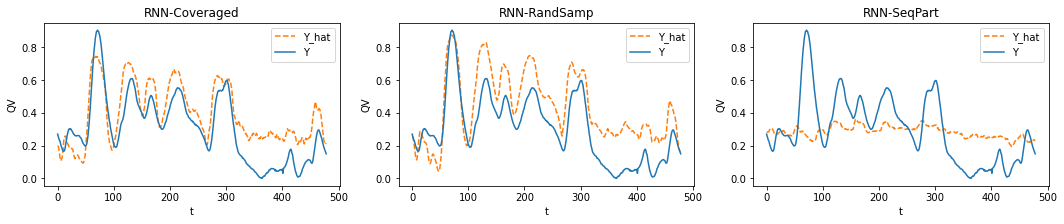

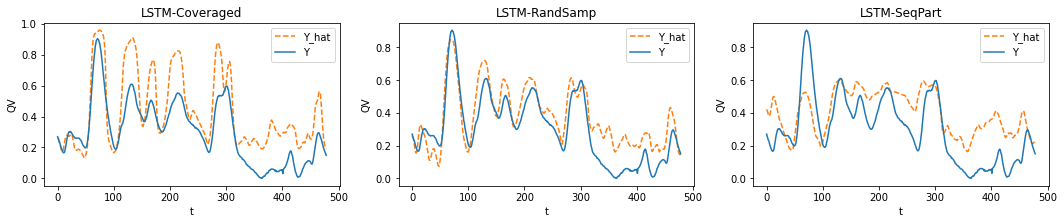

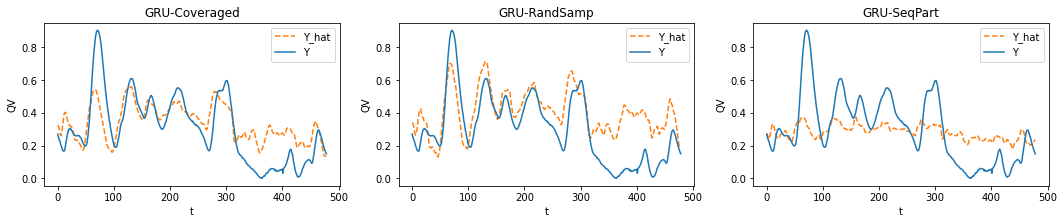

In [52]:
import matplotlib.pyplot as plt

## 1.RNN Results
plt.figure(figsize=(18,3))
# 1.1 RNN-Coveraged
plt.subplot(131, xlabel='t', ylabel='QV', title='RNN-Coveraged')
plt.plot(Y_hat_RNN_coverged, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()
# 1.2 RNN-RandSamp
plt.subplot(132, xlabel='t', ylabel='QV', title='RNN-RandSamp')
plt.plot(Y_hat_RNN_randSamp, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()
# 1.3 RNN-SeqPart
plt.subplot(133, xlabel='t', ylabel='QV', title='RNN-SeqPart')
plt.plot(Y_hat_RNN_seqPart, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()

## 2.LSTM Results
plt.figure(figsize=(18,3))
# 2.1 LSTM-Coveraged
plt.subplot(131, xlabel='t', ylabel='QV', title='LSTM-Coveraged')
plt.plot(Y_hat_LSTM_coverged, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()
# 2.2 LSTM-RandSamp
plt.subplot(132, xlabel='t', ylabel='QV', title='LSTM-RandSamp')
plt.plot(Y_hat_LSTM_randSamp, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()
# 2.3 LSTM-SeqPart
plt.subplot(133, xlabel='t', ylabel='QV', title='LSTM-SeqPart')
plt.plot(Y_hat_LSTM_seqPart, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()

## 3.GRU Results
plt.figure(figsize=(18,3))
# 3.1 GRU-Coveraged
plt.subplot(131, xlabel='t', ylabel='QV', title='GRU-Coveraged')
plt.plot(Y_hat_GRU_coverged, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()
# 3.2 GRU-RandSamp
plt.subplot(132, xlabel='t', ylabel='QV', title='GRU-RandSamp')
plt.plot(Y_hat_GRU_randSamp, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()
# 3.3 GRU-SeqPart
plt.subplot(133, xlabel='t', ylabel='QV', title='GRU-SeqPart')
plt.plot(Y_hat_GRU_seqPart, color='tab:orange', label='Y_hat', linestyle='--')
plt.plot(Y, color='tab:blue', label='Y')
plt.legend()

## 参考文献
[1] L. Fortuna, S. Graziani, A. Rizzo, and M. G. Xibilia, Soft Sensors for Monitoring and Control of Industrial Processes. London, U.K.: Springer-Verlag, 2007.

[2] Z. Chai, C. Zhao, and B. Huang, “Variational Progressive-Transfer Network for Soft Sensing of Multirate Industrial Processes,” IEEE Transactions on Cybernetics, pp. 1–11, 2021, doi: 10.1109/TCYB.2021.3090996.